#### Import packages

In [1]:
import warnings
warnings.filterwarnings('ignore')
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'
import pickle
import pandas as pd
import numpy as np
from sklearn.metrics import roc_curve,auc
import matplotlib.pyplot as plt

#### Load 1st stacking layer models and 2nd stacking layer model or metalearner

In [2]:
models = {}
for model in ['LR','RF','KNN','ET','XGB','LGBM','DT','AB']:
    models[model] = pickle.load(open('Data/model_layer1_'+model+'.dat','rb'))
metalearner = pickle.load(open('Data/model_layer2_metalearner.dat','rb'))

#### Load preprocessed data splits

*Note:* The data splits contain all preprocessing including normalization and one hot encoding.

In [3]:
train,validation,test = pickle.load(open('Data/data_splits.dat','rb'))
target = 'treatment'
features = list(train.columns)
features.remove(target)
x_test,y_test = test[features],test[target]

#### Feature importance

For studying the feature importance (at population level) we will compute the *AUC* in *test* split after randomly permuting all features (feature by feature leaving the rest of features as original data) several times with different seeds. Then, we will create a feature importance indicator using the standard deviation of all permutations' AUC for each feature. The higher standard deviation the more importance because it means that changing the feature values affect more to the predictions.

*Note*: We can get the feature importance indicators for the metalearner or 2nd stacking layer model, but also for the 1st stacking layer models.

In [4]:
features_to_permute = ['Age','anonymity','benefits','care_options','coworkers','family_history','Gender','leave',
                       'mental_health_consequence','mental_health_interview','mental_vs_physical','no_employees',
                       'obs_consequence','phys_health_consequence','phys_health_interview','remote_work','seek_help',
                       'self_employed','supervisor','tech_company','wellness_program','work_interfere']
AUCs = {}
seeds = np.arange(1,15)
for feature_to_permute in features_to_permute:
    AUCs[feature_to_permute] = pd.DataFrame(data=None,index=['seed_'+str(seed) for seed in seeds])
    features_to_permute_ohe = [feature for feature in x_test.columns if feature_to_permute in feature]
    for seed in seeds:
        x_test_permuted = x_test
        # Permutation of test split
        np.random.seed(seed)
        x_test_permuted[features_to_permute_ohe] = x_test_permuted.loc[np.random.permutation(x_test_permuted.index),features_to_permute_ohe].values
        # 1st stacking layer prediction
        for model in models.keys():
            test['prediction_'+model] = models[model].predict_proba(x_test_permuted)[:,1]
            [fpr_test,tpr_test,thr_test] = roc_curve(y_test,test['prediction_'+model])
            AUCs[feature_to_permute].loc['seed_'+str(seed),model] = auc(fpr_test,tpr_test)
        # 2nd stacking layer prediction
        columns_predictions = ['prediction_'+model for model in models.keys()]
        x_test_permuted = test[columns_predictions]
        [fpr_test,tpr_test,thr_test] = roc_curve(y_test,metalearner.predict_proba(x_test_permuted)[:,1])
        AUCs[feature_to_permute].loc['seed_'+str(seed),'Metalearner'] = auc(fpr_test,tpr_test)
    AUCs[feature_to_permute]

,LR,RF,KNN,ET,XGB,LGBM,DT,AB,Metalearner
seed_1,0.862127,0.863759,0.814969,0.866865,0.864151,0.864427,0.821557,0.867525,0.871657
seed_2,0.860960,0.863277,0.797327,0.865912,0.863857,0.863857,0.812397,0.866103,0.870810
seed_3,0.863781,0.865929,0.801268,0.869415,0.864133,0.864543,0.811738,0.868194,0.873431
seed_4,0.862110,0.863848,0.798228,0.867177,0.864516,0.864606,0.822119,0.866290,0.872335
seed_5,0.861503,0.866585,0.808471,0.869277,0.864307,0.863852,0.815299,0.865100,0.872531
seed_6,0.861276,0.862823,0.804562,0.866616,0.864191,0.864557,0.821651,0.866478,0.872112
seed_7,0.861075,0.865060,0.797680,0.867949,0.864196,0.864142,0.816257,0.866041,0.871835
seed_8,0.866299,0.868577,0.794680,0.868902,0.864548,0.865034,0.812901,0.868426,0.873904
seed_9,0.866157,0.866678,0.815313,0.867779,0.864967,0.865751,0.817581,0.870284,0.873431
seed_10,0.862448,0.868100,0.806679,0.867213,0.864240,0.864356,0.812861,0.866531,0.872138


,LR,RF,KNN,ET,XGB,LGBM,DT,AB,Metalearner
seed_1,0.858374,0.866879,0.804285,0.866183,0.862689,0.862680,0.804031,0.863999,0.869188
seed_2,0.860229,0.866442,0.799454,0.865016,0.863460,0.863496,0.803880,0.866237,0.870409
seed_3,0.860077,0.865916,0.799115,0.867066,0.863135,0.863063,0.808083,0.865805,0.869714
seed_4,0.860104,0.867307,0.799823,0.864677,0.863349,0.863554,0.805449,0.865983,0.870623
seed_5,0.859801,0.863964,0.792050,0.865524,0.863300,0.863362,0.810098,0.865992,0.870569
seed_6,0.858874,0.861191,0.793976,0.864008,0.863072,0.863090,0.798237,0.864071,0.867021
seed_7,0.860229,0.865310,0.801753,0.864543,0.863607,0.863563,0.797960,0.866134,0.868787
seed_8,0.860826,0.870275,0.803675,0.871354,0.863728,0.863674,0.814804,0.867855,0.874082
seed_9,0.859712,0.861851,0.796677,0.864303,0.863273,0.863210,0.804410,0.864762,0.868243
seed_10,0.859943,0.867227,0.797189,0.864347,0.863349,0.863331,0.801201,0.866567,0.869509


,LR,RF,KNN,ET,XGB,LGBM,DT,AB,Metalearner
seed_1,0.856957,0.857581,0.782752,0.858847,0.861936,0.861954,0.784254,0.862876,0.862065
seed_2,0.857037,0.855459,0.776909,0.855914,0.861873,0.861668,0.792674,0.862640,0.863144
seed_3,0.857314,0.853667,0.794591,0.861138,0.862881,0.862729,0.798032,0.861454,0.865194
seed_4,0.856337,0.855548,0.789549,0.854086,0.861762,0.861851,0.783412,0.862052,0.861717
seed_5,0.856796,0.859863,0.784794,0.852731,0.862439,0.862475,0.785935,0.862248,0.861940
seed_6,0.855682,0.860077,0.797238,0.859079,0.861530,0.861334,0.788533,0.861682,0.863616
seed_7,0.858089,0.861075,0.797532,0.857773,0.863148,0.862792,0.796908,0.863366,0.865328
seed_8,0.857073,0.859765,0.790107,0.859756,0.862355,0.862417,0.781923,0.863117,0.863928
seed_9,0.856226,0.856538,0.768792,0.854791,0.861494,0.861637,0.789754,0.862457,0.862956
seed_10,0.857839,0.854978,0.784272,0.858000,0.862426,0.862506,0.771667,0.862609,0.861967


,LR,RF,KNN,ET,XGB,LGBM,DT,AB,Metalearner
seed_1,0.844628,0.837898,0.756686,0.834867,0.850530,0.850614,0.756106,0.852183,0.844833
seed_2,0.849362,0.845430,0.770147,0.841477,0.855758,0.855923,0.761424,0.856912,0.850209
seed_3,0.844869,0.839342,0.767031,0.836926,0.852098,0.852214,0.751373,0.852807,0.846028
seed_4,0.849237,0.844280,0.766167,0.839565,0.857055,0.857077,0.766996,0.857051,0.850449
seed_5,0.845511,0.845181,0.757658,0.839493,0.851528,0.851867,0.749617,0.852624,0.847195
seed_6,0.843866,0.842292,0.751912,0.841704,0.850587,0.850302,0.754774,0.852205,0.846687
seed_7,0.849348,0.846081,0.762681,0.843772,0.855580,0.855562,0.765422,0.857599,0.851885
seed_8,0.848399,0.847980,0.774470,0.846184,0.855415,0.855941,0.759155,0.856128,0.851786
seed_9,0.850525,0.847552,0.772411,0.844824,0.856881,0.856828,0.766363,0.857371,0.852580
seed_10,0.849019,0.847686,0.758634,0.843781,0.855874,0.855785,0.760305,0.856890,0.850770


,LR,RF,KNN,ET,XGB,LGBM,DT,AB,Metalearner
seed_1,0.846242,0.840055,0.760377,0.837189,0.853462,0.853596,0.762391,0.853779,0.848747
seed_2,0.846242,0.839279,0.751926,0.836034,0.853462,0.853596,0.752349,0.853779,0.845921
seed_3,0.846242,0.841000,0.748654,0.841142,0.853462,0.853596,0.758683,0.853779,0.849094
seed_4,0.846242,0.839984,0.746898,0.836632,0.853462,0.853596,0.750223,0.853779,0.846741
seed_5,0.846242,0.840724,0.758767,0.835455,0.853462,0.853596,0.759900,0.853779,0.847686
seed_6,0.846242,0.842818,0.759088,0.835277,0.853462,0.853596,0.756031,0.853779,0.848007
seed_7,0.846242,0.841535,0.749068,0.838709,0.853462,0.853596,0.758050,0.853779,0.848069
seed_8,0.846242,0.842230,0.764210,0.838985,0.853462,0.853596,0.752353,0.853779,0.848078
seed_9,0.846242,0.840768,0.745146,0.834020,0.853462,0.853596,0.760729,0.853779,0.848738
seed_10,0.846242,0.841285,0.750749,0.834831,0.853462,0.853596,0.761023,0.853779,0.847686


,LR,RF,KNN,ET,XGB,LGBM,DT,AB,Metalearner
seed_1,0.798468,0.785881,0.690192,0.790535,0.795460,0.795585,0.703363,0.809153,0.793592
seed_2,0.798379,0.786336,0.682557,0.785810,0.797604,0.797434,0.713851,0.810187,0.795170
seed_3,0.804682,0.790401,0.695385,0.788707,0.802199,0.802502,0.712358,0.815816,0.800127
seed_4,0.813035,0.796989,0.694832,0.793467,0.815486,0.815504,0.719726,0.823884,0.810566
seed_5,0.798442,0.790499,0.677066,0.783733,0.798197,0.798509,0.700328,0.809318,0.796062
seed_6,0.802765,0.783608,0.682954,0.782939,0.799993,0.800064,0.704750,0.812999,0.796400
seed_7,0.799708,0.788261,0.685628,0.796641,0.797675,0.797809,0.711190,0.811600,0.799708
seed_8,0.799039,0.792291,0.697021,0.789590,0.799454,0.799864,0.724865,0.810802,0.800670
seed_9,0.801535,0.790847,0.688320,0.786264,0.801651,0.801829,0.703118,0.813071,0.797461
seed_10,0.800492,0.796311,0.695077,0.796044,0.798691,0.798772,0.700435,0.810552,0.798834


,LR,RF,KNN,ET,XGB,LGBM,DT,AB,Metalearner
seed_1,0.776860,0.775201,0.674012,0.766189,0.776097,0.776427,0.717021,0.786536,0.778143
seed_2,0.771796,0.767553,0.665089,0.761179,0.770833,0.771012,0.717275,0.782262,0.772081
seed_3,0.781415,0.778010,0.679143,0.770147,0.780033,0.780381,0.712670,0.792861,0.781237
seed_4,0.778598,0.778598,0.676428,0.764780,0.778749,0.779061,0.708801,0.789665,0.778429
seed_5,0.773855,0.772696,0.674864,0.762133,0.771306,0.771440,0.713071,0.782502,0.774078
seed_6,0.778152,0.775433,0.673682,0.763916,0.777657,0.777577,0.716896,0.788324,0.777876
seed_7,0.771957,0.768177,0.673691,0.752113,0.772286,0.772384,0.708213,0.781509,0.768952
seed_8,0.775522,0.773374,0.666163,0.754208,0.774051,0.774141,0.714899,0.785507,0.773472
seed_9,0.777885,0.776699,0.679227,0.769264,0.776374,0.776686,0.711797,0.788582,0.778946
seed_10,0.783465,0.780550,0.685610,0.765351,0.781237,0.781513,0.709412,0.793860,0.780925


,LR,RF,KNN,ET,XGB,LGBM,DT,AB,Metalearner
seed_1,0.764442,0.759458,0.668026,0.760154,0.766791,0.767299,0.694810,0.773392,0.769113
seed_2,0.765329,0.758558,0.662343,0.762124,0.767281,0.768021,0.692572,0.775384,0.767740
seed_3,0.767205,0.760591,0.664786,0.757943,0.768538,0.769046,0.702361,0.776583,0.769648
seed_4,0.765681,0.759209,0.666132,0.759360,0.767397,0.767949,0.697694,0.775215,0.767856
seed_5,0.763760,0.755589,0.662258,0.753807,0.765623,0.766247,0.673379,0.771832,0.762890
seed_6,0.771890,0.761321,0.657057,0.762061,0.772861,0.773022,0.690816,0.781344,0.772028
seed_7,0.770432,0.767330,0.679606,0.762195,0.771234,0.771600,0.698969,0.780657,0.771867
seed_8,0.764812,0.757337,0.669831,0.754466,0.767713,0.768516,0.691177,0.772986,0.767018
seed_9,0.772852,0.762997,0.667259,0.757996,0.773940,0.773797,0.705213,0.783140,0.771725
seed_10,0.769666,0.761803,0.665575,0.762828,0.771087,0.771194,0.686716,0.779739,0.770753


,LR,RF,KNN,ET,XGB,LGBM,DT,AB,Metalearner
seed_1,0.770018,0.760100,0.662976,0.764807,0.772367,0.772358,0.682806,0.78047,0.770334
seed_2,0.769982,0.758389,0.667144,0.761295,0.772367,0.772358,0.684090,0.78047,0.768747
seed_3,0.769964,0.759868,0.668998,0.765003,0.772367,0.772358,0.686323,0.78047,0.770851
seed_4,0.770298,0.761081,0.662753,0.762908,0.772367,0.772358,0.681639,0.78047,0.770129
seed_5,0.769808,0.759690,0.664353,0.759672,0.772367,0.772358,0.682049,0.78047,0.768783
seed_6,0.770334,0.759146,0.666658,0.762792,0.772367,0.772358,0.683404,0.78047,0.769443
seed_7,0.770218,0.759129,0.672167,0.763755,0.772367,0.772358,0.684353,0.78047,0.769291
seed_8,0.769857,0.758585,0.662334,0.765743,0.772367,0.772358,0.681255,0.78047,0.769746
seed_9,0.770134,0.759316,0.669912,0.765173,0.772367,0.772358,0.686791,0.78047,0.770521
seed_10,0.769955,0.762061,0.678536,0.762356,0.772367,0.772358,0.686198,0.78047,0.770307


,LR,RF,KNN,ET,XGB,LGBM,DT,AB,Metalearner
seed_1,0.76971,0.758834,0.673250,0.758781,0.772367,0.772358,0.680845,0.78047,0.767508
seed_2,0.76971,0.761839,0.658394,0.764192,0.772367,0.772358,0.693531,0.78047,0.771983
seed_3,0.76971,0.761223,0.670772,0.760929,0.772367,0.772358,0.681839,0.78047,0.768364
seed_4,0.76971,0.758362,0.668597,0.760582,0.772367,0.772358,0.683337,0.78047,0.768337
seed_5,0.76971,0.760697,0.659776,0.762890,0.772367,0.772358,0.682334,0.78047,0.769683
seed_6,0.76971,0.760555,0.669644,0.760466,0.772367,0.772358,0.681599,0.78047,0.768195
seed_7,0.76971,0.761981,0.668124,0.761161,0.772367,0.772358,0.684331,0.78047,0.769683
seed_8,0.76971,0.759316,0.665490,0.761870,0.772367,0.772358,0.687469,0.78047,0.770281
seed_9,0.76971,0.759895,0.674262,0.762614,0.772367,0.772358,0.682330,0.78047,0.768961
seed_10,0.76971,0.761286,0.667661,0.760537,0.772367,0.772358,0.686083,0.78047,0.769915


,LR,RF,KNN,ET,XGB,LGBM,DT,AB,Metalearner
seed_1,0.76971,0.763211,0.669800,0.765583,0.772367,0.772358,0.682842,0.78047,0.771119
seed_2,0.76971,0.760956,0.656468,0.763951,0.772367,0.772358,0.690562,0.78047,0.770931
seed_3,0.76971,0.760252,0.657730,0.761036,0.772367,0.772358,0.683283,0.78047,0.770031
seed_4,0.76971,0.761946,0.670045,0.762668,0.772367,0.772358,0.687518,0.78047,0.771511
seed_5,0.76971,0.762079,0.659294,0.762596,0.772367,0.772358,0.687834,0.78047,0.770762
seed_6,0.76971,0.762044,0.659593,0.760983,0.772367,0.772358,0.683337,0.78047,0.770147
seed_7,0.76971,0.764682,0.666956,0.762864,0.772367,0.772358,0.685432,0.78047,0.770807
seed_8,0.76971,0.761785,0.660533,0.761723,0.772367,0.772358,0.684692,0.78047,0.771154
seed_9,0.76971,0.763033,0.671877,0.764932,0.772367,0.772358,0.685414,0.78047,0.770842
seed_10,0.76971,0.762855,0.664492,0.764174,0.772367,0.772358,0.679272,0.78047,0.770655


,LR,RF,KNN,ET,XGB,LGBM,DT,AB,Metalearner
seed_1,0.76971,0.762935,0.661857,0.769309,0.772367,0.772358,0.677596,0.78047,0.772019
seed_2,0.76971,0.763862,0.671338,0.764130,0.772367,0.772358,0.676067,0.78047,0.770423
seed_3,0.76971,0.762587,0.660382,0.767642,0.772367,0.772358,0.685525,0.78047,0.771226
seed_4,0.76971,0.762364,0.663043,0.765030,0.772367,0.772358,0.678149,0.78047,0.770744
seed_5,0.76971,0.759868,0.669305,0.765208,0.772367,0.772358,0.675176,0.78047,0.769434
seed_6,0.76971,0.760626,0.676014,0.767642,0.772367,0.772358,0.681367,0.78047,0.770477
seed_7,0.76971,0.760564,0.664385,0.771110,0.772367,0.772358,0.686016,0.78047,0.771752
seed_8,0.76971,0.757996,0.666952,0.767009,0.772367,0.772358,0.673999,0.78047,0.769389
seed_9,0.76971,0.762570,0.668262,0.766840,0.772367,0.772358,0.687433,0.78047,0.772162
seed_10,0.76971,0.759824,0.666381,0.764673,0.772367,0.772358,0.677070,0.78047,0.769826


,LR,RF,KNN,ET,XGB,LGBM,DT,AB,Metalearner
seed_1,0.76971,0.755821,0.665450,0.763211,0.772367,0.772358,0.661746,0.778063,0.766857
seed_2,0.76971,0.758308,0.663128,0.762632,0.772367,0.772358,0.666809,0.778656,0.767544
seed_3,0.76971,0.760163,0.657168,0.764513,0.772367,0.772358,0.667469,0.778714,0.768756
seed_4,0.76971,0.756775,0.660293,0.759271,0.772367,0.772358,0.664683,0.779472,0.766180
seed_5,0.76971,0.755687,0.661389,0.762195,0.772367,0.772358,0.665343,0.777604,0.766857
seed_6,0.76971,0.757399,0.655608,0.764923,0.772367,0.772358,0.668276,0.778183,0.768658
seed_7,0.76971,0.758897,0.660346,0.763720,0.772367,0.772358,0.667469,0.777069,0.768337
seed_8,0.76971,0.757479,0.661929,0.761732,0.772367,0.772358,0.664554,0.778464,0.766902
seed_9,0.76971,0.756882,0.659553,0.764245,0.772367,0.772358,0.657605,0.778544,0.766982
seed_10,0.76971,0.757292,0.661799,0.762801,0.772367,0.772358,0.660418,0.779333,0.767214


,LR,RF,KNN,ET,XGB,LGBM,DT,AB,Metalearner
seed_1,0.76971,0.753753,0.653812,0.756624,0.772367,0.772358,0.659210,0.776204,0.764442
seed_2,0.76971,0.755509,0.650424,0.756062,0.772367,0.772358,0.660952,0.776204,0.764647
seed_3,0.76971,0.755536,0.646257,0.753967,0.772367,0.772358,0.662450,0.776204,0.764905
seed_4,0.76971,0.755170,0.655720,0.756392,0.772367,0.772358,0.668837,0.776204,0.765494
seed_5,0.76971,0.755928,0.641639,0.758754,0.772367,0.772358,0.666332,0.776204,0.766376
seed_6,0.76971,0.756231,0.656442,0.756632,0.772367,0.772358,0.658915,0.776204,0.764825
seed_7,0.76971,0.754805,0.649903,0.758415,0.772367,0.772358,0.660507,0.776204,0.765440
seed_8,0.76971,0.756641,0.645619,0.759057,0.772367,0.772358,0.663649,0.776204,0.766742
seed_9,0.76971,0.755063,0.647349,0.757577,0.772367,0.772358,0.659272,0.776204,0.764834
seed_10,0.76971,0.755723,0.643578,0.757408,0.772367,0.772358,0.657150,0.776204,0.764798


,LR,RF,KNN,ET,XGB,LGBM,DT,AB,Metalearner
seed_1,0.769612,0.753610,0.623444,0.749688,0.771997,0.771957,0.648882,0.775233,0.763987
seed_2,0.766978,0.751756,0.639656,0.745213,0.771680,0.771827,0.653723,0.772242,0.761883
seed_3,0.769688,0.756080,0.637792,0.746711,0.772295,0.772367,0.664389,0.775451,0.764593
seed_4,0.769086,0.753922,0.641091,0.746158,0.772184,0.772228,0.650732,0.775317,0.761937
seed_5,0.769946,0.756320,0.639005,0.746532,0.772099,0.772246,0.648142,0.775937,0.762828
seed_6,0.770000,0.753860,0.651191,0.745529,0.772340,0.772603,0.660984,0.777243,0.763087
seed_7,0.770985,0.757230,0.646524,0.748868,0.772696,0.772652,0.662031,0.777885,0.764237
seed_8,0.769144,0.752282,0.642767,0.751712,0.772331,0.772300,0.653700,0.775268,0.762079
seed_9,0.768863,0.750303,0.642415,0.746060,0.772246,0.772514,0.658693,0.776811,0.761580
seed_10,0.768520,0.753022,0.629493,0.746176,0.771827,0.771939,0.646836,0.774297,0.761143


,LR,RF,KNN,ET,XGB,LGBM,DT,AB,Metalearner
seed_1,0.766287,0.749510,0.622847,0.749657,0.770579,0.770726,0.665499,0.772549,0.762391
seed_2,0.763586,0.749180,0.615328,0.742574,0.768413,0.768774,0.646965,0.769269,0.756508
seed_3,0.766055,0.746978,0.629720,0.739472,0.770602,0.770878,0.648441,0.771783,0.756312
seed_4,0.766991,0.754297,0.626966,0.746385,0.770637,0.771132,0.661768,0.773561,0.761901
seed_5,0.764869,0.742735,0.618849,0.732296,0.768623,0.769144,0.651726,0.771025,0.753780
seed_6,0.765360,0.749100,0.619094,0.744758,0.770223,0.770628,0.645232,0.771292,0.758879
seed_7,0.764415,0.750071,0.621323,0.738420,0.767651,0.768065,0.649109,0.769527,0.754734
seed_8,0.766724,0.749002,0.617356,0.740234,0.771248,0.771471,0.650772,0.772955,0.758112
seed_9,0.766670,0.753619,0.626177,0.743323,0.771444,0.771711,0.652198,0.773071,0.760020
seed_10,0.767936,0.755438,0.638408,0.742801,0.773066,0.773075,0.653473,0.774060,0.759084


,LR,RF,KNN,ET,XGB,LGBM,DT,AB,Metalearner
seed_1,0.759775,0.736200,0.583485,0.727223,0.767535,0.767651,0.638572,0.768128,0.749938
seed_2,0.750165,0.723452,0.587389,0.715305,0.763421,0.763871,0.627719,0.758536,0.738063
seed_3,0.753847,0.730566,0.587389,0.714975,0.765413,0.765551,0.632573,0.761968,0.741157
seed_4,0.755942,0.734221,0.579050,0.727125,0.766296,0.766474,0.622468,0.764339,0.745632
seed_5,0.756517,0.733544,0.583677,0.725556,0.766073,0.766171,0.642892,0.763720,0.747468
seed_6,0.759646,0.737154,0.602023,0.723622,0.767749,0.767949,0.643230,0.764188,0.748618
seed_7,0.757381,0.737805,0.595502,0.731030,0.766367,0.766898,0.651102,0.762048,0.749117
seed_8,0.755447,0.728881,0.577249,0.727375,0.765948,0.766131,0.632056,0.762561,0.744526
seed_9,0.759646,0.731074,0.584974,0.720101,0.767397,0.767575,0.645642,0.765855,0.747433
seed_10,0.756543,0.732866,0.595769,0.726938,0.765788,0.766051,0.640814,0.764375,0.745757


,LR,RF,KNN,ET,XGB,LGBM,DT,AB,Metalearner
seed_1,0.755759,0.727205,0.581818,0.721768,0.766251,0.766367,0.635996,0.760791,0.743876
seed_2,0.755759,0.727419,0.577699,0.720377,0.766251,0.766367,0.636094,0.760791,0.743573
seed_3,0.755759,0.726252,0.584564,0.722534,0.766251,0.766367,0.634182,0.760791,0.743706
seed_4,0.755759,0.727036,0.585326,0.721170,0.766251,0.766367,0.637173,0.760791,0.744134
seed_5,0.755759,0.725280,0.581287,0.720413,0.766251,0.766367,0.637271,0.760791,0.743394
seed_6,0.755759,0.726876,0.579879,0.722454,0.766251,0.766367,0.637908,0.760791,0.744535
seed_7,0.755759,0.727509,0.582420,0.721955,0.766251,0.766367,0.636094,0.760791,0.743680
seed_8,0.755759,0.724932,0.579478,0.718398,0.766251,0.766367,0.635457,0.760791,0.742396
seed_9,0.755759,0.724995,0.580605,0.720002,0.766251,0.766367,0.636634,0.760791,0.743064
seed_10,0.755759,0.726332,0.584608,0.723426,0.766251,0.766367,0.636732,0.760791,0.743849


,LR,RF,KNN,ET,XGB,LGBM,DT,AB,Metalearner
seed_1,0.754078,0.724647,0.593260,0.714663,0.767753,0.768021,0.643097,0.759953,0.743180
seed_2,0.750856,0.722409,0.575560,0.711355,0.763751,0.764152,0.635648,0.755794,0.739766
seed_3,0.752041,0.720430,0.577632,0.711293,0.764517,0.764838,0.638506,0.756552,0.740078
seed_4,0.752630,0.723577,0.584737,0.710954,0.764223,0.764535,0.643957,0.756013,0.739695
seed_5,0.752937,0.723479,0.581038,0.712051,0.765574,0.765939,0.641795,0.758513,0.740782
seed_6,0.754359,0.726073,0.580681,0.712193,0.766340,0.766768,0.645343,0.760024,0.743198
seed_7,0.754417,0.723319,0.591530,0.713976,0.766358,0.766643,0.640596,0.759494,0.740978
seed_8,0.752893,0.724977,0.585419,0.715126,0.765288,0.765690,0.645116,0.757747,0.741825
seed_9,0.754662,0.723372,0.586066,0.712907,0.767673,0.768083,0.635858,0.761727,0.741701
seed_10,0.753289,0.720840,0.574530,0.709198,0.763938,0.764312,0.641693,0.756539,0.739971


,LR,RF,KNN,ET,XGB,LGBM,DT,AB,Metalearner
seed_1,0.750847,0.718064,0.570528,0.708864,0.764254,0.76454,0.634802,0.754814,0.738442
seed_2,0.750847,0.717711,0.573933,0.711297,0.764254,0.76454,0.633308,0.754814,0.738438
seed_3,0.750847,0.717903,0.569534,0.706947,0.764254,0.76454,0.636067,0.754814,0.738166
seed_4,0.750847,0.717631,0.580588,0.708645,0.764254,0.76454,0.637070,0.754814,0.738197
seed_5,0.750847,0.717890,0.569748,0.708084,0.764254,0.76454,0.638269,0.754814,0.737778
seed_6,0.750847,0.717145,0.578025,0.705160,0.764254,0.76454,0.631882,0.754814,0.737123
seed_7,0.750847,0.718728,0.571562,0.709742,0.764254,0.76454,0.631962,0.754814,0.738848
seed_8,0.750847,0.718697,0.573777,0.709702,0.764254,0.76454,0.638675,0.754814,0.739209
seed_9,0.750847,0.717333,0.568709,0.706813,0.764254,0.76454,0.638564,0.754814,0.737774
seed_10,0.750847,0.719258,0.569636,0.706956,0.764254,0.76454,0.637677,0.754814,0.737658


,LR,RF,KNN,ET,XGB,LGBM,DT,AB,Metalearner
seed_1,0.750847,0.715376,0.575520,0.706265,0.764254,0.76454,0.638697,0.754814,0.736931
seed_2,0.750847,0.715978,0.573612,0.709185,0.764254,0.76454,0.646136,0.754814,0.738157
seed_3,0.750847,0.720159,0.577169,0.709711,0.764254,0.76454,0.655720,0.754814,0.739298
seed_4,0.750847,0.717836,0.579892,0.709546,0.764254,0.76454,0.644336,0.754814,0.738759
seed_5,0.750847,0.715719,0.569730,0.707687,0.764254,0.76454,0.646974,0.754814,0.737578
seed_6,0.750847,0.716802,0.581760,0.707406,0.764254,0.76454,0.647505,0.754814,0.737849
seed_7,0.750847,0.714631,0.564207,0.705967,0.764254,0.76454,0.644033,0.754814,0.737586
seed_8,0.750847,0.713553,0.576728,0.708498,0.764254,0.76454,0.648463,0.754814,0.737988
seed_9,0.750847,0.715305,0.574958,0.704803,0.764254,0.76454,0.654070,0.754814,0.737698
seed_10,0.750847,0.715135,0.567675,0.705699,0.764254,0.76454,0.640538,0.754814,0.735327


,LR,RF,KNN,ET,XGB,LGBM,DT,AB,Metalearner
seed_1,0.458614,0.454032,0.457999,0.463263,0.463036,0.462006,0.483575,0.462831,0.461485
seed_2,0.502398,0.500896,0.484556,0.509547,0.507216,0.506628,0.485344,0.505046,0.503811
seed_3,0.527305,0.520147,0.492886,0.513693,0.524297,0.523450,0.527550,0.520125,0.525576
seed_4,0.496501,0.489124,0.483749,0.489294,0.496755,0.495418,0.499109,0.491340,0.492810
seed_5,0.495106,0.483588,0.462447,0.483758,0.499639,0.498386,0.486053,0.495418,0.491785
seed_6,0.470769,0.463762,0.451362,0.464235,0.478271,0.477669,0.477353,0.476439,0.469231
seed_7,0.506156,0.494063,0.472695,0.498458,0.508375,0.507426,0.503619,0.508808,0.499741
seed_8,0.535623,0.510016,0.496202,0.513211,0.533902,0.532997,0.512770,0.527394,0.524105
seed_9,0.501114,0.494625,0.462229,0.495177,0.503396,0.502572,0.492583,0.500245,0.499719
seed_10,0.503089,0.494781,0.472628,0.508264,0.504364,0.503267,0.502608,0.503419,0.503321


In [5]:
for feature_to_permute in features_to_permute:
    print('Permuting several times the feature '+feature_to_permute+' we obtain these AUCs for each permutation:')
    AUCs[feature_to_permute]

Permuting several times the feature Age we obtain these AUCs for each permutation:


,LR,RF,KNN,ET,XGB,LGBM,DT,AB,Metalearner
seed_1,0.862127,0.863759,0.814969,0.866865,0.864151,0.864427,0.821557,0.867525,0.871657
seed_2,0.860960,0.863277,0.797327,0.865912,0.863857,0.863857,0.812397,0.866103,0.870810
seed_3,0.863781,0.865929,0.801268,0.869415,0.864133,0.864543,0.811738,0.868194,0.873431
seed_4,0.862110,0.863848,0.798228,0.867177,0.864516,0.864606,0.822119,0.866290,0.872335
seed_5,0.861503,0.866585,0.808471,0.869277,0.864307,0.863852,0.815299,0.865100,0.872531
seed_6,0.861276,0.862823,0.804562,0.866616,0.864191,0.864557,0.821651,0.866478,0.872112
seed_7,0.861075,0.865060,0.797680,0.867949,0.864196,0.864142,0.816257,0.866041,0.871835
seed_8,0.866299,0.868577,0.794680,0.868902,0.864548,0.865034,0.812901,0.868426,0.873904
seed_9,0.866157,0.866678,0.815313,0.867779,0.864967,0.865751,0.817581,0.870284,0.873431
seed_10,0.862448,0.868100,0.806679,0.867213,0.864240,0.864356,0.812861,0.866531,0.872138


Permuting several times the feature anonymity we obtain these AUCs for each permutation:


,LR,RF,KNN,ET,XGB,LGBM,DT,AB,Metalearner
seed_1,0.858374,0.866879,0.804285,0.866183,0.862689,0.862680,0.804031,0.863999,0.869188
seed_2,0.860229,0.866442,0.799454,0.865016,0.863460,0.863496,0.803880,0.866237,0.870409
seed_3,0.860077,0.865916,0.799115,0.867066,0.863135,0.863063,0.808083,0.865805,0.869714
seed_4,0.860104,0.867307,0.799823,0.864677,0.863349,0.863554,0.805449,0.865983,0.870623
seed_5,0.859801,0.863964,0.792050,0.865524,0.863300,0.863362,0.810098,0.865992,0.870569
seed_6,0.858874,0.861191,0.793976,0.864008,0.863072,0.863090,0.798237,0.864071,0.867021
seed_7,0.860229,0.865310,0.801753,0.864543,0.863607,0.863563,0.797960,0.866134,0.868787
seed_8,0.860826,0.870275,0.803675,0.871354,0.863728,0.863674,0.814804,0.867855,0.874082
seed_9,0.859712,0.861851,0.796677,0.864303,0.863273,0.863210,0.804410,0.864762,0.868243
seed_10,0.859943,0.867227,0.797189,0.864347,0.863349,0.863331,0.801201,0.866567,0.869509


Permuting several times the feature benefits we obtain these AUCs for each permutation:


,LR,RF,KNN,ET,XGB,LGBM,DT,AB,Metalearner
seed_1,0.856957,0.857581,0.782752,0.858847,0.861936,0.861954,0.784254,0.862876,0.862065
seed_2,0.857037,0.855459,0.776909,0.855914,0.861873,0.861668,0.792674,0.862640,0.863144
seed_3,0.857314,0.853667,0.794591,0.861138,0.862881,0.862729,0.798032,0.861454,0.865194
seed_4,0.856337,0.855548,0.789549,0.854086,0.861762,0.861851,0.783412,0.862052,0.861717
seed_5,0.856796,0.859863,0.784794,0.852731,0.862439,0.862475,0.785935,0.862248,0.861940
seed_6,0.855682,0.860077,0.797238,0.859079,0.861530,0.861334,0.788533,0.861682,0.863616
seed_7,0.858089,0.861075,0.797532,0.857773,0.863148,0.862792,0.796908,0.863366,0.865328
seed_8,0.857073,0.859765,0.790107,0.859756,0.862355,0.862417,0.781923,0.863117,0.863928
seed_9,0.856226,0.856538,0.768792,0.854791,0.861494,0.861637,0.789754,0.862457,0.862956
seed_10,0.857839,0.854978,0.784272,0.858000,0.862426,0.862506,0.771667,0.862609,0.861967


Permuting several times the feature care_options we obtain these AUCs for each permutation:


,LR,RF,KNN,ET,XGB,LGBM,DT,AB,Metalearner
seed_1,0.844628,0.837898,0.756686,0.834867,0.850530,0.850614,0.756106,0.852183,0.844833
seed_2,0.849362,0.845430,0.770147,0.841477,0.855758,0.855923,0.761424,0.856912,0.850209
seed_3,0.844869,0.839342,0.767031,0.836926,0.852098,0.852214,0.751373,0.852807,0.846028
seed_4,0.849237,0.844280,0.766167,0.839565,0.857055,0.857077,0.766996,0.857051,0.850449
seed_5,0.845511,0.845181,0.757658,0.839493,0.851528,0.851867,0.749617,0.852624,0.847195
seed_6,0.843866,0.842292,0.751912,0.841704,0.850587,0.850302,0.754774,0.852205,0.846687
seed_7,0.849348,0.846081,0.762681,0.843772,0.855580,0.855562,0.765422,0.857599,0.851885
seed_8,0.848399,0.847980,0.774470,0.846184,0.855415,0.855941,0.759155,0.856128,0.851786
seed_9,0.850525,0.847552,0.772411,0.844824,0.856881,0.856828,0.766363,0.857371,0.852580
seed_10,0.849019,0.847686,0.758634,0.843781,0.855874,0.855785,0.760305,0.856890,0.850770


Permuting several times the feature coworkers we obtain these AUCs for each permutation:


,LR,RF,KNN,ET,XGB,LGBM,DT,AB,Metalearner
seed_1,0.846242,0.840055,0.760377,0.837189,0.853462,0.853596,0.762391,0.853779,0.848747
seed_2,0.846242,0.839279,0.751926,0.836034,0.853462,0.853596,0.752349,0.853779,0.845921
seed_3,0.846242,0.841000,0.748654,0.841142,0.853462,0.853596,0.758683,0.853779,0.849094
seed_4,0.846242,0.839984,0.746898,0.836632,0.853462,0.853596,0.750223,0.853779,0.846741
seed_5,0.846242,0.840724,0.758767,0.835455,0.853462,0.853596,0.759900,0.853779,0.847686
seed_6,0.846242,0.842818,0.759088,0.835277,0.853462,0.853596,0.756031,0.853779,0.848007
seed_7,0.846242,0.841535,0.749068,0.838709,0.853462,0.853596,0.758050,0.853779,0.848069
seed_8,0.846242,0.842230,0.764210,0.838985,0.853462,0.853596,0.752353,0.853779,0.848078
seed_9,0.846242,0.840768,0.745146,0.834020,0.853462,0.853596,0.760729,0.853779,0.848738
seed_10,0.846242,0.841285,0.750749,0.834831,0.853462,0.853596,0.761023,0.853779,0.847686


Permuting several times the feature family_history we obtain these AUCs for each permutation:


,LR,RF,KNN,ET,XGB,LGBM,DT,AB,Metalearner
seed_1,0.798468,0.785881,0.690192,0.790535,0.795460,0.795585,0.703363,0.809153,0.793592
seed_2,0.798379,0.786336,0.682557,0.785810,0.797604,0.797434,0.713851,0.810187,0.795170
seed_3,0.804682,0.790401,0.695385,0.788707,0.802199,0.802502,0.712358,0.815816,0.800127
seed_4,0.813035,0.796989,0.694832,0.793467,0.815486,0.815504,0.719726,0.823884,0.810566
seed_5,0.798442,0.790499,0.677066,0.783733,0.798197,0.798509,0.700328,0.809318,0.796062
seed_6,0.802765,0.783608,0.682954,0.782939,0.799993,0.800064,0.704750,0.812999,0.796400
seed_7,0.799708,0.788261,0.685628,0.796641,0.797675,0.797809,0.711190,0.811600,0.799708
seed_8,0.799039,0.792291,0.697021,0.789590,0.799454,0.799864,0.724865,0.810802,0.800670
seed_9,0.801535,0.790847,0.688320,0.786264,0.801651,0.801829,0.703118,0.813071,0.797461
seed_10,0.800492,0.796311,0.695077,0.796044,0.798691,0.798772,0.700435,0.810552,0.798834


Permuting several times the feature Gender we obtain these AUCs for each permutation:


,LR,RF,KNN,ET,XGB,LGBM,DT,AB,Metalearner
seed_1,0.776860,0.775201,0.674012,0.766189,0.776097,0.776427,0.717021,0.786536,0.778143
seed_2,0.771796,0.767553,0.665089,0.761179,0.770833,0.771012,0.717275,0.782262,0.772081
seed_3,0.781415,0.778010,0.679143,0.770147,0.780033,0.780381,0.712670,0.792861,0.781237
seed_4,0.778598,0.778598,0.676428,0.764780,0.778749,0.779061,0.708801,0.789665,0.778429
seed_5,0.773855,0.772696,0.674864,0.762133,0.771306,0.771440,0.713071,0.782502,0.774078
seed_6,0.778152,0.775433,0.673682,0.763916,0.777657,0.777577,0.716896,0.788324,0.777876
seed_7,0.771957,0.768177,0.673691,0.752113,0.772286,0.772384,0.708213,0.781509,0.768952
seed_8,0.775522,0.773374,0.666163,0.754208,0.774051,0.774141,0.714899,0.785507,0.773472
seed_9,0.777885,0.776699,0.679227,0.769264,0.776374,0.776686,0.711797,0.788582,0.778946
seed_10,0.783465,0.780550,0.685610,0.765351,0.781237,0.781513,0.709412,0.793860,0.780925


Permuting several times the feature leave we obtain these AUCs for each permutation:


,LR,RF,KNN,ET,XGB,LGBM,DT,AB,Metalearner
seed_1,0.764442,0.759458,0.668026,0.760154,0.766791,0.767299,0.694810,0.773392,0.769113
seed_2,0.765329,0.758558,0.662343,0.762124,0.767281,0.768021,0.692572,0.775384,0.767740
seed_3,0.767205,0.760591,0.664786,0.757943,0.768538,0.769046,0.702361,0.776583,0.769648
seed_4,0.765681,0.759209,0.666132,0.759360,0.767397,0.767949,0.697694,0.775215,0.767856
seed_5,0.763760,0.755589,0.662258,0.753807,0.765623,0.766247,0.673379,0.771832,0.762890
seed_6,0.771890,0.761321,0.657057,0.762061,0.772861,0.773022,0.690816,0.781344,0.772028
seed_7,0.770432,0.767330,0.679606,0.762195,0.771234,0.771600,0.698969,0.780657,0.771867
seed_8,0.764812,0.757337,0.669831,0.754466,0.767713,0.768516,0.691177,0.772986,0.767018
seed_9,0.772852,0.762997,0.667259,0.757996,0.773940,0.773797,0.705213,0.783140,0.771725
seed_10,0.769666,0.761803,0.665575,0.762828,0.771087,0.771194,0.686716,0.779739,0.770753


Permuting several times the feature mental_health_consequence we obtain these AUCs for each permutation:


,LR,RF,KNN,ET,XGB,LGBM,DT,AB,Metalearner
seed_1,0.770018,0.760100,0.662976,0.764807,0.772367,0.772358,0.682806,0.78047,0.770334
seed_2,0.769982,0.758389,0.667144,0.761295,0.772367,0.772358,0.684090,0.78047,0.768747
seed_3,0.769964,0.759868,0.668998,0.765003,0.772367,0.772358,0.686323,0.78047,0.770851
seed_4,0.770298,0.761081,0.662753,0.762908,0.772367,0.772358,0.681639,0.78047,0.770129
seed_5,0.769808,0.759690,0.664353,0.759672,0.772367,0.772358,0.682049,0.78047,0.768783
seed_6,0.770334,0.759146,0.666658,0.762792,0.772367,0.772358,0.683404,0.78047,0.769443
seed_7,0.770218,0.759129,0.672167,0.763755,0.772367,0.772358,0.684353,0.78047,0.769291
seed_8,0.769857,0.758585,0.662334,0.765743,0.772367,0.772358,0.681255,0.78047,0.769746
seed_9,0.770134,0.759316,0.669912,0.765173,0.772367,0.772358,0.686791,0.78047,0.770521
seed_10,0.769955,0.762061,0.678536,0.762356,0.772367,0.772358,0.686198,0.78047,0.770307


Permuting several times the feature mental_health_interview we obtain these AUCs for each permutation:


,LR,RF,KNN,ET,XGB,LGBM,DT,AB,Metalearner
seed_1,0.76971,0.758834,0.673250,0.758781,0.772367,0.772358,0.680845,0.78047,0.767508
seed_2,0.76971,0.761839,0.658394,0.764192,0.772367,0.772358,0.693531,0.78047,0.771983
seed_3,0.76971,0.761223,0.670772,0.760929,0.772367,0.772358,0.681839,0.78047,0.768364
seed_4,0.76971,0.758362,0.668597,0.760582,0.772367,0.772358,0.683337,0.78047,0.768337
seed_5,0.76971,0.760697,0.659776,0.762890,0.772367,0.772358,0.682334,0.78047,0.769683
seed_6,0.76971,0.760555,0.669644,0.760466,0.772367,0.772358,0.681599,0.78047,0.768195
seed_7,0.76971,0.761981,0.668124,0.761161,0.772367,0.772358,0.684331,0.78047,0.769683
seed_8,0.76971,0.759316,0.665490,0.761870,0.772367,0.772358,0.687469,0.78047,0.770281
seed_9,0.76971,0.759895,0.674262,0.762614,0.772367,0.772358,0.682330,0.78047,0.768961
seed_10,0.76971,0.761286,0.667661,0.760537,0.772367,0.772358,0.686083,0.78047,0.769915


Permuting several times the feature mental_vs_physical we obtain these AUCs for each permutation:


,LR,RF,KNN,ET,XGB,LGBM,DT,AB,Metalearner
seed_1,0.76971,0.763211,0.669800,0.765583,0.772367,0.772358,0.682842,0.78047,0.771119
seed_2,0.76971,0.760956,0.656468,0.763951,0.772367,0.772358,0.690562,0.78047,0.770931
seed_3,0.76971,0.760252,0.657730,0.761036,0.772367,0.772358,0.683283,0.78047,0.770031
seed_4,0.76971,0.761946,0.670045,0.762668,0.772367,0.772358,0.687518,0.78047,0.771511
seed_5,0.76971,0.762079,0.659294,0.762596,0.772367,0.772358,0.687834,0.78047,0.770762
seed_6,0.76971,0.762044,0.659593,0.760983,0.772367,0.772358,0.683337,0.78047,0.770147
seed_7,0.76971,0.764682,0.666956,0.762864,0.772367,0.772358,0.685432,0.78047,0.770807
seed_8,0.76971,0.761785,0.660533,0.761723,0.772367,0.772358,0.684692,0.78047,0.771154
seed_9,0.76971,0.763033,0.671877,0.764932,0.772367,0.772358,0.685414,0.78047,0.770842
seed_10,0.76971,0.762855,0.664492,0.764174,0.772367,0.772358,0.679272,0.78047,0.770655


Permuting several times the feature no_employees we obtain these AUCs for each permutation:


,LR,RF,KNN,ET,XGB,LGBM,DT,AB,Metalearner
seed_1,0.76971,0.762935,0.661857,0.769309,0.772367,0.772358,0.677596,0.78047,0.772019
seed_2,0.76971,0.763862,0.671338,0.764130,0.772367,0.772358,0.676067,0.78047,0.770423
seed_3,0.76971,0.762587,0.660382,0.767642,0.772367,0.772358,0.685525,0.78047,0.771226
seed_4,0.76971,0.762364,0.663043,0.765030,0.772367,0.772358,0.678149,0.78047,0.770744
seed_5,0.76971,0.759868,0.669305,0.765208,0.772367,0.772358,0.675176,0.78047,0.769434
seed_6,0.76971,0.760626,0.676014,0.767642,0.772367,0.772358,0.681367,0.78047,0.770477
seed_7,0.76971,0.760564,0.664385,0.771110,0.772367,0.772358,0.686016,0.78047,0.771752
seed_8,0.76971,0.757996,0.666952,0.767009,0.772367,0.772358,0.673999,0.78047,0.769389
seed_9,0.76971,0.762570,0.668262,0.766840,0.772367,0.772358,0.687433,0.78047,0.772162
seed_10,0.76971,0.759824,0.666381,0.764673,0.772367,0.772358,0.677070,0.78047,0.769826


Permuting several times the feature obs_consequence we obtain these AUCs for each permutation:


,LR,RF,KNN,ET,XGB,LGBM,DT,AB,Metalearner
seed_1,0.76971,0.755821,0.665450,0.763211,0.772367,0.772358,0.661746,0.778063,0.766857
seed_2,0.76971,0.758308,0.663128,0.762632,0.772367,0.772358,0.666809,0.778656,0.767544
seed_3,0.76971,0.760163,0.657168,0.764513,0.772367,0.772358,0.667469,0.778714,0.768756
seed_4,0.76971,0.756775,0.660293,0.759271,0.772367,0.772358,0.664683,0.779472,0.766180
seed_5,0.76971,0.755687,0.661389,0.762195,0.772367,0.772358,0.665343,0.777604,0.766857
seed_6,0.76971,0.757399,0.655608,0.764923,0.772367,0.772358,0.668276,0.778183,0.768658
seed_7,0.76971,0.758897,0.660346,0.763720,0.772367,0.772358,0.667469,0.777069,0.768337
seed_8,0.76971,0.757479,0.661929,0.761732,0.772367,0.772358,0.664554,0.778464,0.766902
seed_9,0.76971,0.756882,0.659553,0.764245,0.772367,0.772358,0.657605,0.778544,0.766982
seed_10,0.76971,0.757292,0.661799,0.762801,0.772367,0.772358,0.660418,0.779333,0.767214


Permuting several times the feature phys_health_consequence we obtain these AUCs for each permutation:


,LR,RF,KNN,ET,XGB,LGBM,DT,AB,Metalearner
seed_1,0.76971,0.753753,0.653812,0.756624,0.772367,0.772358,0.659210,0.776204,0.764442
seed_2,0.76971,0.755509,0.650424,0.756062,0.772367,0.772358,0.660952,0.776204,0.764647
seed_3,0.76971,0.755536,0.646257,0.753967,0.772367,0.772358,0.662450,0.776204,0.764905
seed_4,0.76971,0.755170,0.655720,0.756392,0.772367,0.772358,0.668837,0.776204,0.765494
seed_5,0.76971,0.755928,0.641639,0.758754,0.772367,0.772358,0.666332,0.776204,0.766376
seed_6,0.76971,0.756231,0.656442,0.756632,0.772367,0.772358,0.658915,0.776204,0.764825
seed_7,0.76971,0.754805,0.649903,0.758415,0.772367,0.772358,0.660507,0.776204,0.765440
seed_8,0.76971,0.756641,0.645619,0.759057,0.772367,0.772358,0.663649,0.776204,0.766742
seed_9,0.76971,0.755063,0.647349,0.757577,0.772367,0.772358,0.659272,0.776204,0.764834
seed_10,0.76971,0.755723,0.643578,0.757408,0.772367,0.772358,0.657150,0.776204,0.764798


Permuting several times the feature phys_health_interview we obtain these AUCs for each permutation:


,LR,RF,KNN,ET,XGB,LGBM,DT,AB,Metalearner
seed_1,0.769612,0.753610,0.623444,0.749688,0.771997,0.771957,0.648882,0.775233,0.763987
seed_2,0.766978,0.751756,0.639656,0.745213,0.771680,0.771827,0.653723,0.772242,0.761883
seed_3,0.769688,0.756080,0.637792,0.746711,0.772295,0.772367,0.664389,0.775451,0.764593
seed_4,0.769086,0.753922,0.641091,0.746158,0.772184,0.772228,0.650732,0.775317,0.761937
seed_5,0.769946,0.756320,0.639005,0.746532,0.772099,0.772246,0.648142,0.775937,0.762828
seed_6,0.770000,0.753860,0.651191,0.745529,0.772340,0.772603,0.660984,0.777243,0.763087
seed_7,0.770985,0.757230,0.646524,0.748868,0.772696,0.772652,0.662031,0.777885,0.764237
seed_8,0.769144,0.752282,0.642767,0.751712,0.772331,0.772300,0.653700,0.775268,0.762079
seed_9,0.768863,0.750303,0.642415,0.746060,0.772246,0.772514,0.658693,0.776811,0.761580
seed_10,0.768520,0.753022,0.629493,0.746176,0.771827,0.771939,0.646836,0.774297,0.761143


Permuting several times the feature remote_work we obtain these AUCs for each permutation:


,LR,RF,KNN,ET,XGB,LGBM,DT,AB,Metalearner
seed_1,0.766287,0.749510,0.622847,0.749657,0.770579,0.770726,0.665499,0.772549,0.762391
seed_2,0.763586,0.749180,0.615328,0.742574,0.768413,0.768774,0.646965,0.769269,0.756508
seed_3,0.766055,0.746978,0.629720,0.739472,0.770602,0.770878,0.648441,0.771783,0.756312
seed_4,0.766991,0.754297,0.626966,0.746385,0.770637,0.771132,0.661768,0.773561,0.761901
seed_5,0.764869,0.742735,0.618849,0.732296,0.768623,0.769144,0.651726,0.771025,0.753780
seed_6,0.765360,0.749100,0.619094,0.744758,0.770223,0.770628,0.645232,0.771292,0.758879
seed_7,0.764415,0.750071,0.621323,0.738420,0.767651,0.768065,0.649109,0.769527,0.754734
seed_8,0.766724,0.749002,0.617356,0.740234,0.771248,0.771471,0.650772,0.772955,0.758112
seed_9,0.766670,0.753619,0.626177,0.743323,0.771444,0.771711,0.652198,0.773071,0.760020
seed_10,0.767936,0.755438,0.638408,0.742801,0.773066,0.773075,0.653473,0.774060,0.759084


Permuting several times the feature seek_help we obtain these AUCs for each permutation:


,LR,RF,KNN,ET,XGB,LGBM,DT,AB,Metalearner
seed_1,0.759775,0.736200,0.583485,0.727223,0.767535,0.767651,0.638572,0.768128,0.749938
seed_2,0.750165,0.723452,0.587389,0.715305,0.763421,0.763871,0.627719,0.758536,0.738063
seed_3,0.753847,0.730566,0.587389,0.714975,0.765413,0.765551,0.632573,0.761968,0.741157
seed_4,0.755942,0.734221,0.579050,0.727125,0.766296,0.766474,0.622468,0.764339,0.745632
seed_5,0.756517,0.733544,0.583677,0.725556,0.766073,0.766171,0.642892,0.763720,0.747468
seed_6,0.759646,0.737154,0.602023,0.723622,0.767749,0.767949,0.643230,0.764188,0.748618
seed_7,0.757381,0.737805,0.595502,0.731030,0.766367,0.766898,0.651102,0.762048,0.749117
seed_8,0.755447,0.728881,0.577249,0.727375,0.765948,0.766131,0.632056,0.762561,0.744526
seed_9,0.759646,0.731074,0.584974,0.720101,0.767397,0.767575,0.645642,0.765855,0.747433
seed_10,0.756543,0.732866,0.595769,0.726938,0.765788,0.766051,0.640814,0.764375,0.745757


Permuting several times the feature self_employed we obtain these AUCs for each permutation:


,LR,RF,KNN,ET,XGB,LGBM,DT,AB,Metalearner
seed_1,0.755759,0.727205,0.581818,0.721768,0.766251,0.766367,0.635996,0.760791,0.743876
seed_2,0.755759,0.727419,0.577699,0.720377,0.766251,0.766367,0.636094,0.760791,0.743573
seed_3,0.755759,0.726252,0.584564,0.722534,0.766251,0.766367,0.634182,0.760791,0.743706
seed_4,0.755759,0.727036,0.585326,0.721170,0.766251,0.766367,0.637173,0.760791,0.744134
seed_5,0.755759,0.725280,0.581287,0.720413,0.766251,0.766367,0.637271,0.760791,0.743394
seed_6,0.755759,0.726876,0.579879,0.722454,0.766251,0.766367,0.637908,0.760791,0.744535
seed_7,0.755759,0.727509,0.582420,0.721955,0.766251,0.766367,0.636094,0.760791,0.743680
seed_8,0.755759,0.724932,0.579478,0.718398,0.766251,0.766367,0.635457,0.760791,0.742396
seed_9,0.755759,0.724995,0.580605,0.720002,0.766251,0.766367,0.636634,0.760791,0.743064
seed_10,0.755759,0.726332,0.584608,0.723426,0.766251,0.766367,0.636732,0.760791,0.743849


Permuting several times the feature supervisor we obtain these AUCs for each permutation:


,LR,RF,KNN,ET,XGB,LGBM,DT,AB,Metalearner
seed_1,0.754078,0.724647,0.593260,0.714663,0.767753,0.768021,0.643097,0.759953,0.743180
seed_2,0.750856,0.722409,0.575560,0.711355,0.763751,0.764152,0.635648,0.755794,0.739766
seed_3,0.752041,0.720430,0.577632,0.711293,0.764517,0.764838,0.638506,0.756552,0.740078
seed_4,0.752630,0.723577,0.584737,0.710954,0.764223,0.764535,0.643957,0.756013,0.739695
seed_5,0.752937,0.723479,0.581038,0.712051,0.765574,0.765939,0.641795,0.758513,0.740782
seed_6,0.754359,0.726073,0.580681,0.712193,0.766340,0.766768,0.645343,0.760024,0.743198
seed_7,0.754417,0.723319,0.591530,0.713976,0.766358,0.766643,0.640596,0.759494,0.740978
seed_8,0.752893,0.724977,0.585419,0.715126,0.765288,0.765690,0.645116,0.757747,0.741825
seed_9,0.754662,0.723372,0.586066,0.712907,0.767673,0.768083,0.635858,0.761727,0.741701
seed_10,0.753289,0.720840,0.574530,0.709198,0.763938,0.764312,0.641693,0.756539,0.739971


Permuting several times the feature tech_company we obtain these AUCs for each permutation:


,LR,RF,KNN,ET,XGB,LGBM,DT,AB,Metalearner
seed_1,0.750847,0.718064,0.570528,0.708864,0.764254,0.76454,0.634802,0.754814,0.738442
seed_2,0.750847,0.717711,0.573933,0.711297,0.764254,0.76454,0.633308,0.754814,0.738438
seed_3,0.750847,0.717903,0.569534,0.706947,0.764254,0.76454,0.636067,0.754814,0.738166
seed_4,0.750847,0.717631,0.580588,0.708645,0.764254,0.76454,0.637070,0.754814,0.738197
seed_5,0.750847,0.717890,0.569748,0.708084,0.764254,0.76454,0.638269,0.754814,0.737778
seed_6,0.750847,0.717145,0.578025,0.705160,0.764254,0.76454,0.631882,0.754814,0.737123
seed_7,0.750847,0.718728,0.571562,0.709742,0.764254,0.76454,0.631962,0.754814,0.738848
seed_8,0.750847,0.718697,0.573777,0.709702,0.764254,0.76454,0.638675,0.754814,0.739209
seed_9,0.750847,0.717333,0.568709,0.706813,0.764254,0.76454,0.638564,0.754814,0.737774
seed_10,0.750847,0.719258,0.569636,0.706956,0.764254,0.76454,0.637677,0.754814,0.737658


Permuting several times the feature wellness_program we obtain these AUCs for each permutation:


,LR,RF,KNN,ET,XGB,LGBM,DT,AB,Metalearner
seed_1,0.750847,0.715376,0.575520,0.706265,0.764254,0.76454,0.638697,0.754814,0.736931
seed_2,0.750847,0.715978,0.573612,0.709185,0.764254,0.76454,0.646136,0.754814,0.738157
seed_3,0.750847,0.720159,0.577169,0.709711,0.764254,0.76454,0.655720,0.754814,0.739298
seed_4,0.750847,0.717836,0.579892,0.709546,0.764254,0.76454,0.644336,0.754814,0.738759
seed_5,0.750847,0.715719,0.569730,0.707687,0.764254,0.76454,0.646974,0.754814,0.737578
seed_6,0.750847,0.716802,0.581760,0.707406,0.764254,0.76454,0.647505,0.754814,0.737849
seed_7,0.750847,0.714631,0.564207,0.705967,0.764254,0.76454,0.644033,0.754814,0.737586
seed_8,0.750847,0.713553,0.576728,0.708498,0.764254,0.76454,0.648463,0.754814,0.737988
seed_9,0.750847,0.715305,0.574958,0.704803,0.764254,0.76454,0.654070,0.754814,0.737698
seed_10,0.750847,0.715135,0.567675,0.705699,0.764254,0.76454,0.640538,0.754814,0.735327


Permuting several times the feature work_interfere we obtain these AUCs for each permutation:


,LR,RF,KNN,ET,XGB,LGBM,DT,AB,Metalearner
seed_1,0.458614,0.454032,0.457999,0.463263,0.463036,0.462006,0.483575,0.462831,0.461485
seed_2,0.502398,0.500896,0.484556,0.509547,0.507216,0.506628,0.485344,0.505046,0.503811
seed_3,0.527305,0.520147,0.492886,0.513693,0.524297,0.523450,0.527550,0.520125,0.525576
seed_4,0.496501,0.489124,0.483749,0.489294,0.496755,0.495418,0.499109,0.491340,0.492810
seed_5,0.495106,0.483588,0.462447,0.483758,0.499639,0.498386,0.486053,0.495418,0.491785
seed_6,0.470769,0.463762,0.451362,0.464235,0.478271,0.477669,0.477353,0.476439,0.469231
seed_7,0.506156,0.494063,0.472695,0.498458,0.508375,0.507426,0.503619,0.508808,0.499741
seed_8,0.535623,0.510016,0.496202,0.513211,0.533902,0.532997,0.512770,0.527394,0.524105
seed_9,0.501114,0.494625,0.462229,0.495177,0.503396,0.502572,0.492583,0.500245,0.499719
seed_10,0.503089,0.494781,0.472628,0.508264,0.504364,0.503267,0.502608,0.503419,0.503321


In [6]:
InteractiveShell.ast_node_interactivity = 'none'

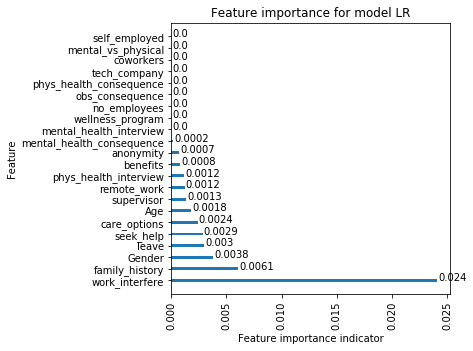

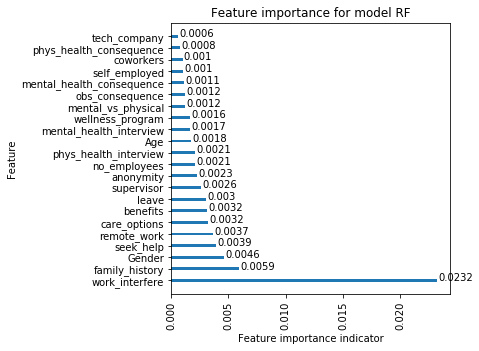

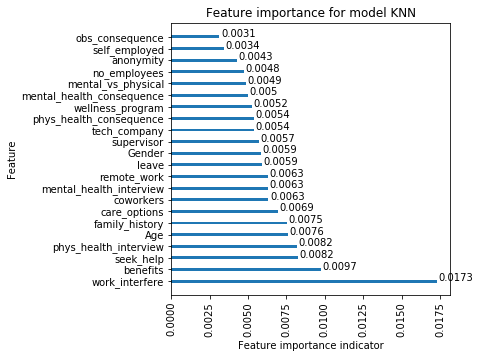

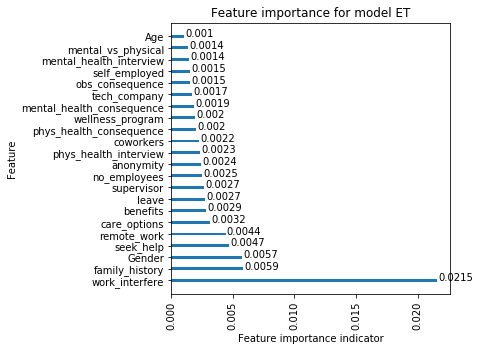

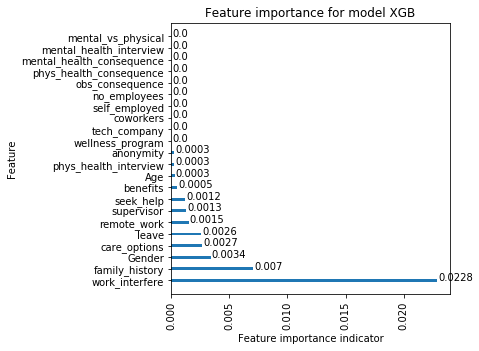

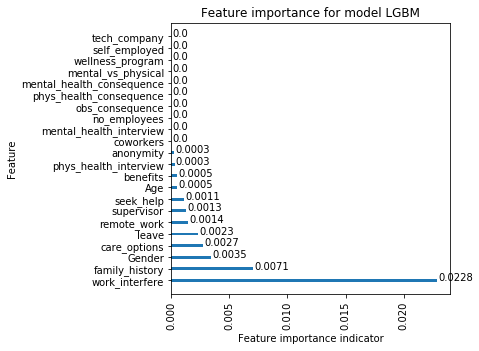

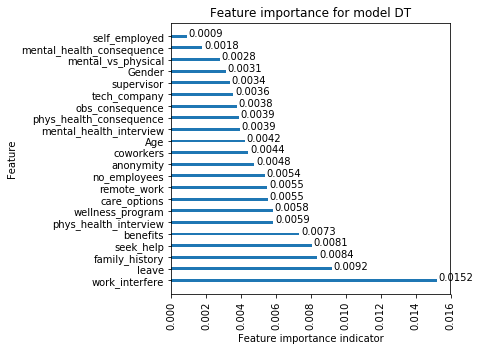

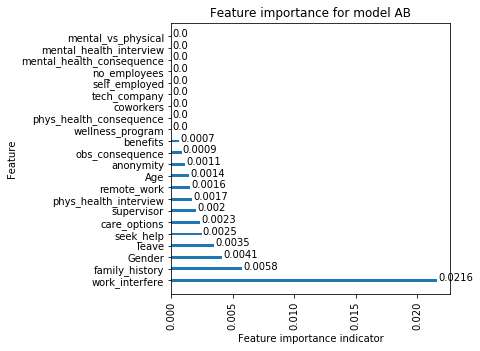

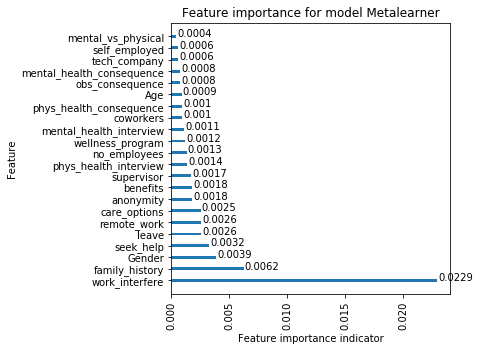

In [7]:
instability = {}
for model in ['LR','RF','KNN','ET','XGB','LGBM','DT','AB','Metalearner']:
    # Compute the features importance (standard deviation of all permutations' AUC for each feature)
    feature_importance = {}
    for feature_to_permute in features_to_permute:
        feature_importance[feature_to_permute] = AUCs[feature_to_permute][model].std()
    feature_importance = pd.DataFrame.from_dict(feature_importance,orient='index',columns=['Importance'])
    feature_importance = feature_importance.iloc[np.argsort(-feature_importance['Importance']),:]
    # Plot the features importance
    fig = plt.figure(figsize=(5,5))
    plt.barh(feature_importance.index,feature_importance['Importance'],height=0.25)
    for feature in feature_importance.index:
        plt.text(feature_importance.loc[feature,'Importance']+0.0001,feature,round(feature_importance.loc[feature,'Importance'],4)) 
    plt.xticks(rotation='vertical')
    plt.title('Feature importance for model '+str(model))
    plt.ylabel('Feature')
    plt.xlabel('Feature importance indicator')
    plt.show()
    # Compute the instability of the model (explained in next section)
    instability[model] = feature_importance['Importance'].sum(axis=0)

#### Model instability

Also, for studying the instability to data noise of the models we will create an instability indicator using the sum of all features importance indicators by models. Basically, we will sum by models the standard deviations of all permutations' AUC of all features. Then, the higher sum of standard deviations the more instability to data noise.

In [8]:
instability = pd.DataFrame.from_dict(instability,orient='index',columns=['Instability'])
instability = instability.iloc[np.argsort(-instability['Instability']).values,:]

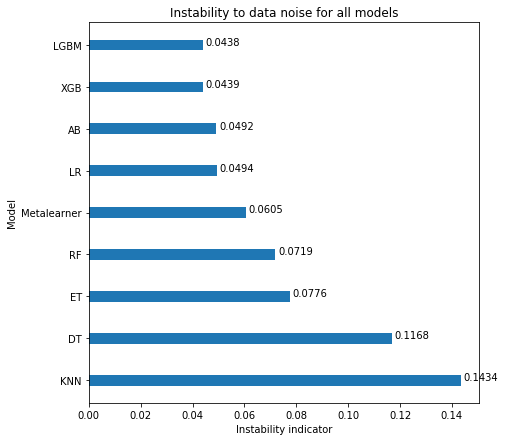

In [9]:
fig = plt.figure(figsize=(7,7))
plt.barh(instability.index,instability['Instability'],height=0.25)
for index,level in enumerate(instability.index):
    plt.text(instability['Instability'][index]+0.001,level,round(instability['Instability'][index],4))    
plt.title('Instability to data noise for all models')
plt.ylabel('Model')
plt.xlabel('Instability indicator')
plt.show()